In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
plt.style.use('ggplot')

In [2]:
WEIGHTS = {'A': .177,
           'B': .151,
           'C': .130,
           'D': .077}

DAYDIV = 167

In [3]:
districts = list(pd.read_csv('districts.csv', header=None).iloc[:,0])
df = pd.read_excel('PoliStat polls (Responses).xlsx', sheet='Form Responses 1')

In [4]:
polls = {district: [] for district in districts}

for index, row in df.iterrows():
    dm = row['Democratic percent (Not margin, not 2-party)']
    w = WEIGHTS[row['Pollster Grade https://projects.fivethirtyeight.com/pollster-ratings/ (Put D if N/A)']]
    year = int(str(row['Final date taken']).split(' ')[0].split('-')[0])
    month = int(str(row['Final date taken']).split(' ')[0].split('-')[1])
    day = int(str(row['Final date taken']).split(' ')[0].split('-')[2])
    
    d0 = date(year, month, day)
    d1 = date(2018, 11, 6)
    days = d1 - d0
    days = days.days
    
    nw = np.exp(days / 30)
    polls[row['District Name (e.g. AZ-03, WA-11)']].append([dm, nw])

In [5]:
# Prior to Python 3.6, dicts do not preserve order and this output will not preserve district order
# Run this thing in 3.6+ (the way this notebook is currently configured to run) or suffer.
for poll in polls:
    if len(polls[poll]) > 0:
        rep = np.array(polls[poll])
        polls[poll] = np.average(rep[:,0], weights=rep[:,1])
    else:
        polls[poll] = 999
with open('ppoll.csv', 'w') as f:
    [f.write('{0},{1}\n'.format(key, value)) for key, value in polls.items()]

In [6]:
print('Done')

Done


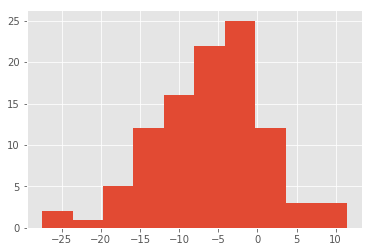

In [7]:
import matplotlib.pyplot as plt
z = ['-7.4', '5.1', '-0.308436908', '1.7', '2.7', '-13.9', '1.314648352', '-8.9', '3.858889869', '-2.548351406', '-7.7', '-2.2', '-8.1', '-1.1', '-16.58648245', '-11.99357074', '-0.979991932', '-5.5', '-2.393510199', '-5.743879167', '-10', '-4.255753574', '-9.143065338', '-1.802229933', '-1', '-6', '-14', '10', '-9.306812838', '-10.14802189', '-4.4', '-4.3', '-2.6', '-19.33192372', '-12.5', '11.39179314', '-10.13330644', '-9.710104255', '-11.22900123', '-4.596605665', '2.384870343', '-1.428040152', '-5.6', '-4.644831589', '-7.4', '-4.786857725', '-15.18991563', '-6.868187772', '2.8', '-27.5', '2.1', '-25.4', '-15.16254264', '-11.79985211', '-13.09007101', '-5.797273862', '-15.2', '-2.243315816', '-10.51104932', '-10.60209063', '-11.40211149', '-23.4', '-0.9', '-6.457718146', '-5.42073582', '9.287596021', '-19.6', '-6.909346717', '-6.6', '-16.1', '-11.79601296', '-7.671148855', '-3.992969417', '-1', '-4.27010199', '-2.925702461', '-15.65796686', '-4.345052532', '2.069739777', '-9.5', '0.7', '-0.7', '-0.8', '-1.651363386', '-18', '0.8', '-1.800575145', '-1.578083142', '2.60029577', '-14.23574983', '-0.066715962', '-3.192472596', '-11.67119073', '-0.666724335', '0.9', '-13.48208627', '-3.859392066', '4.294698378', '-2.907422271', '-3.577762926', '-12.1']
z = [float(rep) for rep in z]
plt.hist(z)
plt.show()